## Constructing the datasets

In [32]:
import librosa
import pandas as pd
import numpy as np
from IPython.lib.display import Audio
from matplotlib import pyplot as plt
import multiprocessing
import scipy.signal

import torch

The audio has been recorded with a sampling rate of 44100.

Let's load the data into the pandas dataframe with annotations. The dataset is small and it can fit into our RAM. This means, that every time we iterate over the dataset, we don't have to load every example from disk.

In [33]:
%%time

anno = pd.read_csv('data/annotations.csv')

audio = []

for _, row in anno.iterrows():
    recording, _ = librosa.load(f'data/audio/{row.filename}', sr=None)
    audio.append(recording)
    
anno['audio'] = audio

CPU times: user 9.3 s, sys: 764 ms, total: 10.1 s
Wall time: 10.1 s


The shortest recording is just 1.04 seconds. The longest one is 178.68 second long. The recordings are 'dense' in vocalizations as dog barks are continous. Given that, taking smaller portions of audio files to create our examples should be okay.

Let's visualize the a recording to illustrate this.

In [214]:
import librosa
import matplotlib.pyplot as plt

recording = anno.iloc[100].audio

print(f'Recording duration in seconds: {recording.shape[0] / 44100}')

features = []
for i in range(15):
    spec = librosa.feature.melspectrogram(recording[i*44100:(i+1)*44100], sr=44100)
    spec_db = librosa.core.amplitude_to_db(spec)
    features.append(spec_db)

Recording duration in seconds: 15.022993197278911


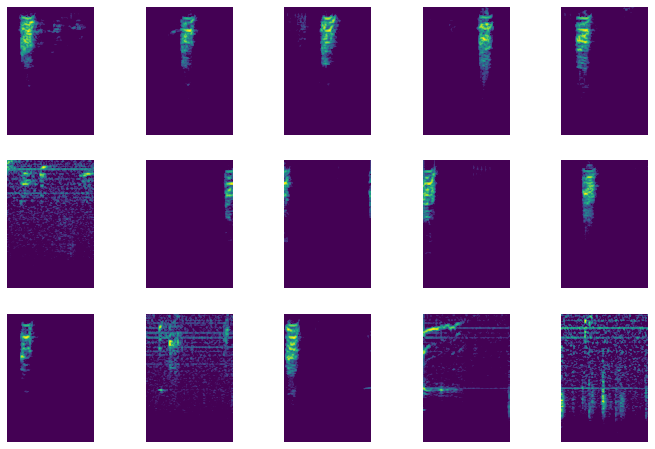

In [215]:
fig, subplots = plt.subplots(3, 5, figsize=(12,8))
for feature, subplot in zip(features, subplots.flatten()):
    subplot.imshow(feature)
    subplot.axis('off')

In [216]:
from IPython.lib.display import Audio

In [217]:
Audio(recording, rate=44100)

Despite cutting the audio into 1 second segments (relatively short period of time), majority of the examples that would be created would still contain enough signal to work with (neural networks are robust to noise as long as it is not systemic).

Of course, the longer the segment we take, the more likely it will contain genuine signal for the neural net to learn from!

Given this, we will provide 4 options for this dataset:
* sample random 1 second from each call for each example (the **sample** option)
* cut each example into examples of 1 second duration (the **cut** option), this will produce some number of new examples, that will depend on the total length of recordings
* pad each example to the longest example in the dataset (the **pad** option)
* take just the 1 of each call from the beginning (the **first** option)

Additionally, the classes are unbalanced.

In [35]:
anno.name.value_counts()

Roodie    152
Luke      117
Mac        86
Zoe        74
Siggy      71
Farley     52
Freid      45
Keri       42
Louie      33
Rudy       21
Name: name, dtype: int64

We provide two versions of the dataset:
* **unbalanced** (examples represented in line with counts in the raw dataset)
* **balanced** (examples upsampled to count of the most frequently occuring class)

In [41]:
class ExampleProcessor():
    def __init__(self, example_length):
        assert example_length in options.keys()
        self.example_length = example_length
    def __call__(self, example):
        return options[self.example_length](example)
    
def first(example):
    return example[:44100]

def sample(example):
    start_frame = np.random.randint(example.shape[0] - 44099)
    return example[start_frame:start_frame+44100]

def pad(example):
    out = np.zeros((7879715))
    out[:example.shape[0]] = example
    return out    

options = {
    'first': first,
    'sample': sample,
    'pad': pad
}

In [23]:
from IPython.lib.display import Audio

In [43]:
anno.head()

,filename,name,context,age,weight,sex,breed,audio
0,Mac-3-A-3.aif,Mac,aggression,5,34,male,German shorthair pointer,"[0.00012207031, 0.00064086914, 0.00010681152, ..."
1,Mac-3-P-3.aif,Mac,play,5,34,male,German shorthair pointer,"[-0.0010375977, -0.0013427734, -0.0014038086, ..."
2,Mac-2-P-2d.aif,Mac,play,5,34,male,German shorthair pointer,"[0.00079345703, 0.00039672852, 0.00012207031, ..."
3,Mac-2-P-2b.aif,Mac,play,5,34,male,German shorthair pointer,"[-0.00036621094, 0.00050354004, -0.0004119873,..."
4,Mac-2-A-2a..aif,Mac,aggression,5,34,male,German shorthair pointer,"[-7.6293945e-05, 0.00093078613, 0.00044250488,..."


There are 6 targets you can pick from: `name`, `context`, `age`, `weight`, `sex` and `breed`. Weight and age are continuous variables.

In [153]:
target_name = 'age'

if target_name in ['name', 'context', 'sex', 'breed']:
    target_type = 'label' 
else:
    target_type = 'continous'

In [154]:
class Row2Target():
    def __init__(self):
        self.label2idx = {label:i for i, label in enumerate(anno[target_name].unique())}
        
    def __call__(self, row):
        if target_type == 'continous':
            return row[target_name]
        else:
            return self.label2idx[row[target_name]]

In [155]:
r2t = Row2Target()

In [156]:
example = 'first'

if example == 'cut':
    cls = []
    audio = []

    for idx, row in df.iterrows():
        while True:
            if row.audio.shape[0] < 44100: break
            cls.append(row[target_name])
            audio.append(row.audio[:44100])
            row.audio = row.audio[44100:]
    df = pd.DataFrame({target_name: cls, 'audio': audio})
    example = 'first'

In [160]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, example=example, classes='unbalanced'):
        self.examples = df
        self.example_processor = ExampleProcessor(example)
        
        assert classes in ['balanced', 'unbalanced']
        if classes=='balanced':
            max_examples = self.examples[target_name].value_counts().iloc[0]
            for grp in self.examples.groupby(target_name):
                example_count = self.examples[self.examples[target_name] == grp[0]].shape[0]
                while example_count < max_examples:
                    self.examples = self.examples.append(self.examples[self.examples[target_name] == grp[0]][:max_examples-example_count])
                    example_count = self.examples[self.examples[target_name] == grp[0]].shape[0]
        
    def __getitem__(self, index):
        example = self.examples.iloc[index]
        x = self.example_processor(example.audio)
        y = r2t(example)
        return x, y

    def __len__(self):
        return self.examples.shape[0]

In [161]:
target_name

'age'

In [162]:
anno[target_name].value_counts()

5     248
12    152
11     92
7      74
3      52
4      42
2      33
Name: age, dtype: int64

In [163]:
train_ds = Dataset(anno[:600], example='first', classes='balanced')
valid_ds = Dataset(anno[600:], example='first')

In [164]:
len(train_ds)

1085

In [165]:
train_ds.examples[target_name].value_counts()

12    155
11    155
7     155
5     155
4     155
3     155
2     155
Name: age, dtype: int64

In [166]:
train_dl = torch.utils.data.DataLoader(
    dataset=train_ds,
    batch_size=32,
    shuffle=True,
    num_workers=multiprocessing.cpu_count()-1
)

valid_dl = torch.utils.data.DataLoader(
    dataset=valid_ds,
    batch_size=32,
    shuffle=False,
    num_workers=multiprocessing.cpu_count()-1
)

In [167]:
for batch in train_dl: pass
for batch in valid_dl: pass

In [168]:
batch[0].shape, batch[1].shape # we are on the final batch, there were not enough examples to fill it

(torch.Size([29, 44100]), torch.Size([29]))

In [169]:
anno.shape

(693, 8)